# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

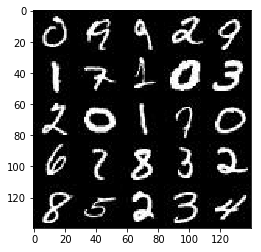

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

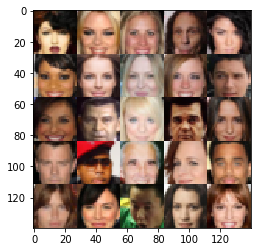

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_input = tf.placeholder(tf.float32, [None, z_dim])
    lr = tf.placeholder(tf.float32)

    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
?tf.layers.dense

In [7]:
def discriminator(images, reuse=False, alpha=0.01, training=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Define leaky relu so we don't need to write it every time
    def lrelu(tensor):
        return tf.maximum(alpha*tensor, tensor)
    
    # Define the batch normalized convolutional layer 
    def conv2d_batch_normalized(input_, depth, kernel_size, stride_size, activation=None):
        conv = tf.layers.conv2d(input_, depth, kernel_size, strides=stride_size, padding='same', use_bias=False,
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        conv = tf.layers.batch_normalization(conv, training=training)
        if activation is not None:
            conv = activation(conv)
        return conv
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # Apply some convolutions
        conv1 = conv2d_batch_normalized(images, 256, 5, 2, lrelu) 
        conv2 = conv2d_batch_normalized(conv1, 512, 5, 2, lrelu)
        conv3 = conv2d_batch_normalized(conv2, 1024, 5, 2, lrelu)
        
        shape = conv3.get_shape().as_list()
        
        # Reshape, get logits and sigmoid
        flattened = tf.reshape(conv3, [-1, shape[1]*shape[2]*shape[3]])
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Define leaky relu so we don't need to write it every time
    def lrelu(tensor):
        return tf.maximum(alpha*tensor, tensor)
    
    # Define the batch normalized transpose convolution
    def conv2d_trans_batch_normalized(input_, depth, kernel_size, stride_size, activation=None, padding='same'):
        conv = tf.layers.conv2d_transpose(input_, depth, kernel_size, strides=stride_size, padding=padding, use_bias=False,
                                          kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        conv = tf.layers.batch_normalization(conv, training=is_train)
        if activation is not None:
            conv = activation(conv)
        return conv
    
    reuse = not is_train
    with tf.variable_scope("generator", reuse=reuse):
        # Get a deep layer from the random input
        x = tf.layers.dense(z, 1024*3*3)
        x = tf.reshape(x, [-1, 3, 3, 1024])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = lrelu(x)
        
        # Apply some transpose convolutions
        conv1 = conv2d_trans_batch_normalized(x, 512, 5, 2, lrelu) # 6x6x512
        conv2 = conv2d_trans_batch_normalized(conv1, 256, 4, 2, lrelu, 'valid') # 14x14x256
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, 2, padding='same', # 28x28x(out_channel_dim)
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02)) 
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.01, smooth=0.01):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_out = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    disc_real_out, disc_real_logits = discriminator(input_real, reuse=False, alpha=alpha)
    disc_fake_out, disc_fake_logits = discriminator(gen_out, reuse=True, alpha=alpha)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels = tf.ones_like(disc_real_logits)*(1-smooth),
        logits = disc_real_logits
    ))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels = tf.zeros_like(disc_fake_logits),
        logits = disc_fake_logits
    ))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels = tf.ones_like(disc_fake_logits),
        logits = disc_fake_logits
    ))
    
    return d_loss_real + d_loss_fake, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        gen_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return disc_opt, gen_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode,alpha=0.01):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False, alpha=alpha),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         alpha = 0.01, print_every=50, show_every=500):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, width, height, channels = data_shape
    input_real, z_input, lr = model_inputs(width, height, channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, z_input, channels, alpha=alpha)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_n = 0           
            for batch_images in get_batches(batch_size):
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(disc_opt, feed_dict={input_real: batch_images, z_input: z_batch, lr: learning_rate})
                
                # Seen in slack: run generator twice to avoid the discriminator overpowering it
                sess.run(gen_opt, feed_dict={input_real: batch_images, z_input: z_batch, lr: learning_rate})
                sess.run(gen_opt, feed_dict={input_real: batch_images, z_input: z_batch, lr: learning_rate})
                
                if batch_n % print_every == 0:
                    dloss = disc_loss.eval({input_real: batch_images, z_input: z_batch, lr: learning_rate})
                    gloss = gen_loss.eval({input_real: batch_images, z_input: z_batch, lr: learning_rate})
                    print("Epoch: {}, Batch: {}, Disc. Loss: {:4f}, Gen. Loss: {:4f}".format(epoch_i+1, batch_n, dloss, gloss))
                
                if batch_n % show_every == 0:
                    show_generator_output(sess, 16, z_input, channels, data_image_mode, alpha=alpha)
                    
                batch_n += 1
            show_generator_output(sess, 16, z_input, channels, data_image_mode)
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1, Batch: 0, Disc. Loss: 1.830484, Gen. Loss: 0.226191


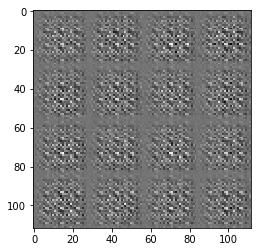

Epoch: 1, Batch: 50, Disc. Loss: 0.437237, Gen. Loss: 1.353325
Epoch: 1, Batch: 100, Disc. Loss: 1.228509, Gen. Loss: 0.656556
Epoch: 1, Batch: 150, Disc. Loss: 1.614938, Gen. Loss: 1.962709
Epoch: 1, Batch: 200, Disc. Loss: 1.086254, Gen. Loss: 0.871836
Epoch: 1, Batch: 250, Disc. Loss: 0.998796, Gen. Loss: 0.657129
Epoch: 1, Batch: 300, Disc. Loss: 0.983218, Gen. Loss: 0.890287
Epoch: 1, Batch: 350, Disc. Loss: 0.893896, Gen. Loss: 1.159276
Epoch: 1, Batch: 400, Disc. Loss: 0.739187, Gen. Loss: 1.408744
Epoch: 1, Batch: 450, Disc. Loss: 0.754624, Gen. Loss: 0.894454
Epoch: 1, Batch: 500, Disc. Loss: 0.440149, Gen. Loss: 2.320684


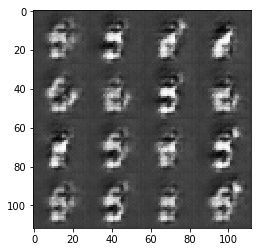

Epoch: 1, Batch: 550, Disc. Loss: 0.735290, Gen. Loss: 0.915656
Epoch: 1, Batch: 600, Disc. Loss: 0.468272, Gen. Loss: 2.103995
Epoch: 1, Batch: 650, Disc. Loss: 0.476824, Gen. Loss: 1.710833
Epoch: 1, Batch: 700, Disc. Loss: 0.502591, Gen. Loss: 1.856144
Epoch: 1, Batch: 750, Disc. Loss: 1.073241, Gen. Loss: 0.722919
Epoch: 1, Batch: 800, Disc. Loss: 0.377156, Gen. Loss: 2.471603
Epoch: 1, Batch: 850, Disc. Loss: 0.487099, Gen. Loss: 1.835412
Epoch: 1, Batch: 900, Disc. Loss: 0.552240, Gen. Loss: 1.297375
Epoch: 1, Batch: 950, Disc. Loss: 0.326639, Gen. Loss: 2.935746
Epoch: 1, Batch: 1000, Disc. Loss: 0.414818, Gen. Loss: 1.854487


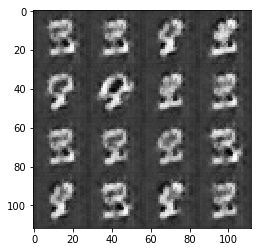

Epoch: 1, Batch: 1050, Disc. Loss: 0.971855, Gen. Loss: 4.931488
Epoch: 1, Batch: 1100, Disc. Loss: 0.490766, Gen. Loss: 1.802317
Epoch: 1, Batch: 1150, Disc. Loss: 0.361564, Gen. Loss: 2.775633
Epoch: 1, Batch: 1200, Disc. Loss: 0.200689, Gen. Loss: 2.802271
Epoch: 1, Batch: 1250, Disc. Loss: 0.782001, Gen. Loss: 1.140309
Epoch: 1, Batch: 1300, Disc. Loss: 0.364762, Gen. Loss: 2.529174
Epoch: 1, Batch: 1350, Disc. Loss: 0.343673, Gen. Loss: 2.173640
Epoch: 1, Batch: 1400, Disc. Loss: 0.428795, Gen. Loss: 1.954215
Epoch: 1, Batch: 1450, Disc. Loss: 1.186906, Gen. Loss: 7.354928
Epoch: 1, Batch: 1500, Disc. Loss: 0.362256, Gen. Loss: 2.430724


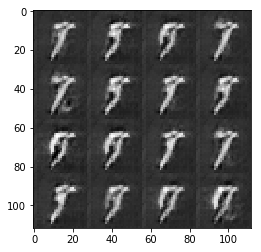

Epoch: 1, Batch: 1550, Disc. Loss: 0.518001, Gen. Loss: 1.347704
Epoch: 1, Batch: 1600, Disc. Loss: 0.480054, Gen. Loss: 1.498960
Epoch: 1, Batch: 1650, Disc. Loss: 0.196198, Gen. Loss: 3.025428
Epoch: 1, Batch: 1700, Disc. Loss: 0.403824, Gen. Loss: 1.565125
Epoch: 1, Batch: 1750, Disc. Loss: 0.173794, Gen. Loss: 3.511904
Epoch: 1, Batch: 1800, Disc. Loss: 1.158147, Gen. Loss: 10.543702
Epoch: 1, Batch: 1850, Disc. Loss: 0.310202, Gen. Loss: 2.251104


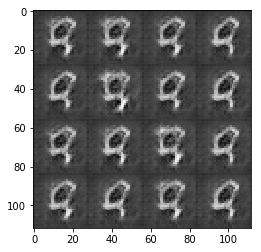

Epoch: 2, Batch: 0, Disc. Loss: 0.313818, Gen. Loss: 1.917062


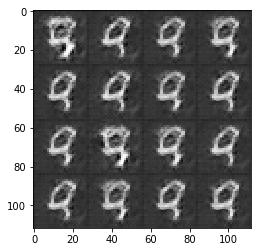

Epoch: 2, Batch: 50, Disc. Loss: 0.490564, Gen. Loss: 2.413177
Epoch: 2, Batch: 100, Disc. Loss: 0.219778, Gen. Loss: 2.655253
Epoch: 2, Batch: 150, Disc. Loss: 0.363328, Gen. Loss: 2.124382
Epoch: 2, Batch: 200, Disc. Loss: 0.351859, Gen. Loss: 1.925904
Epoch: 2, Batch: 250, Disc. Loss: 0.519325, Gen. Loss: 5.056085
Epoch: 2, Batch: 300, Disc. Loss: 0.202389, Gen. Loss: 3.400171
Epoch: 2, Batch: 350, Disc. Loss: 0.171985, Gen. Loss: 2.993454
Epoch: 2, Batch: 400, Disc. Loss: 0.287361, Gen. Loss: 2.305944
Epoch: 2, Batch: 450, Disc. Loss: 0.382700, Gen. Loss: 1.657130
Epoch: 2, Batch: 500, Disc. Loss: 0.109229, Gen. Loss: 4.906466


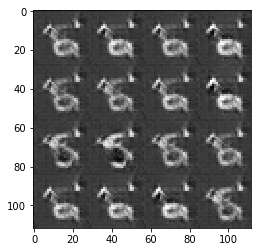

Epoch: 2, Batch: 550, Disc. Loss: 0.427842, Gen. Loss: 1.439247
Epoch: 2, Batch: 600, Disc. Loss: 0.285225, Gen. Loss: 2.143222
Epoch: 2, Batch: 650, Disc. Loss: 0.218969, Gen. Loss: 3.129517
Epoch: 2, Batch: 700, Disc. Loss: 0.653848, Gen. Loss: 1.030006
Epoch: 2, Batch: 750, Disc. Loss: 0.674062, Gen. Loss: 1.318928
Epoch: 2, Batch: 800, Disc. Loss: 0.334747, Gen. Loss: 2.232489
Epoch: 2, Batch: 850, Disc. Loss: 0.125645, Gen. Loss: 3.875744
Epoch: 2, Batch: 900, Disc. Loss: 0.421580, Gen. Loss: 1.413546
Epoch: 2, Batch: 950, Disc. Loss: 0.275616, Gen. Loss: 2.598555
Epoch: 2, Batch: 1000, Disc. Loss: 0.175635, Gen. Loss: 3.893445


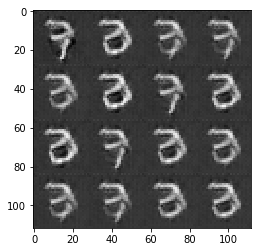

Epoch: 2, Batch: 1050, Disc. Loss: 0.369492, Gen. Loss: 1.888952
Epoch: 2, Batch: 1100, Disc. Loss: 0.141069, Gen. Loss: 3.570304
Epoch: 2, Batch: 1150, Disc. Loss: 0.213721, Gen. Loss: 3.273706
Epoch: 2, Batch: 1200, Disc. Loss: 0.147782, Gen. Loss: 3.156166
Epoch: 2, Batch: 1250, Disc. Loss: 0.255488, Gen. Loss: 2.130988
Epoch: 2, Batch: 1300, Disc. Loss: 0.154221, Gen. Loss: 3.728968
Epoch: 2, Batch: 1350, Disc. Loss: 0.230181, Gen. Loss: 6.098408
Epoch: 2, Batch: 1400, Disc. Loss: 0.117275, Gen. Loss: 5.652719
Epoch: 2, Batch: 1450, Disc. Loss: 0.223245, Gen. Loss: 2.855603
Epoch: 2, Batch: 1500, Disc. Loss: 0.333232, Gen. Loss: 2.403938


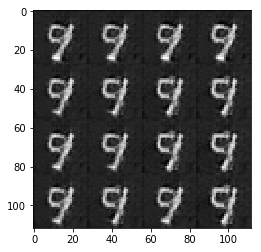

Epoch: 2, Batch: 1550, Disc. Loss: 0.120007, Gen. Loss: 4.616513
Epoch: 2, Batch: 1600, Disc. Loss: 0.179658, Gen. Loss: 4.109796
Epoch: 2, Batch: 1650, Disc. Loss: 0.370928, Gen. Loss: 1.896508
Epoch: 2, Batch: 1700, Disc. Loss: 0.146114, Gen. Loss: 3.020167
Epoch: 2, Batch: 1750, Disc. Loss: 0.133283, Gen. Loss: 3.734937
Epoch: 2, Batch: 1800, Disc. Loss: 0.166750, Gen. Loss: 4.280860
Epoch: 2, Batch: 1850, Disc. Loss: 0.847014, Gen. Loss: 10.647287


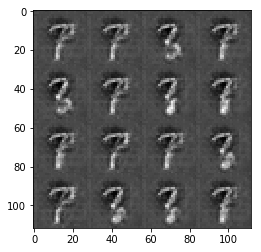

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha=alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1, Batch: 0, Disc. Loss: 1.951797, Gen. Loss: 0.249272


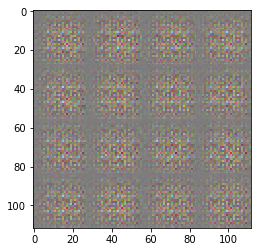

Epoch: 1, Batch: 50, Disc. Loss: 0.252677, Gen. Loss: 2.291553
Epoch: 1, Batch: 100, Disc. Loss: 1.298224, Gen. Loss: 0.718260
Epoch: 1, Batch: 150, Disc. Loss: 1.318316, Gen. Loss: 0.661234
Epoch: 1, Batch: 200, Disc. Loss: 1.320767, Gen. Loss: 0.820863
Epoch: 1, Batch: 250, Disc. Loss: 1.286248, Gen. Loss: 0.804584
Epoch: 1, Batch: 300, Disc. Loss: 1.577340, Gen. Loss: 0.748757
Epoch: 1, Batch: 350, Disc. Loss: 1.269205, Gen. Loss: 0.648150
Epoch: 1, Batch: 400, Disc. Loss: 1.477976, Gen. Loss: 0.601950
Epoch: 1, Batch: 450, Disc. Loss: 1.294513, Gen. Loss: 0.560638
Epoch: 1, Batch: 500, Disc. Loss: 1.389277, Gen. Loss: 0.583255


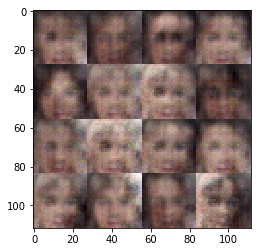

Epoch: 1, Batch: 550, Disc. Loss: 1.690718, Gen. Loss: 0.365210
Epoch: 1, Batch: 600, Disc. Loss: 1.250028, Gen. Loss: 0.772708
Epoch: 1, Batch: 650, Disc. Loss: 1.329434, Gen. Loss: 0.592963
Epoch: 1, Batch: 700, Disc. Loss: 1.311237, Gen. Loss: 0.520863
Epoch: 1, Batch: 750, Disc. Loss: 0.568162, Gen. Loss: 2.756516
Epoch: 1, Batch: 800, Disc. Loss: 1.659488, Gen. Loss: 0.439981
Epoch: 1, Batch: 850, Disc. Loss: 1.972325, Gen. Loss: 0.316235
Epoch: 1, Batch: 900, Disc. Loss: 0.983716, Gen. Loss: 2.111101
Epoch: 1, Batch: 950, Disc. Loss: 1.308644, Gen. Loss: 0.768512
Epoch: 1, Batch: 1000, Disc. Loss: 1.074717, Gen. Loss: 1.025929


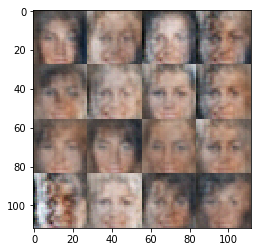

Epoch: 1, Batch: 1050, Disc. Loss: 1.397210, Gen. Loss: 0.664159
Epoch: 1, Batch: 1100, Disc. Loss: 1.247966, Gen. Loss: 0.610435
Epoch: 1, Batch: 1150, Disc. Loss: 1.018988, Gen. Loss: 1.092067
Epoch: 1, Batch: 1200, Disc. Loss: 1.573695, Gen. Loss: 0.568559
Epoch: 1, Batch: 1250, Disc. Loss: 1.096429, Gen. Loss: 1.105816
Epoch: 1, Batch: 1300, Disc. Loss: 1.040193, Gen. Loss: 1.275994
Epoch: 1, Batch: 1350, Disc. Loss: 1.859915, Gen. Loss: 0.375824
Epoch: 1, Batch: 1400, Disc. Loss: 1.273484, Gen. Loss: 1.052357
Epoch: 1, Batch: 1450, Disc. Loss: 1.494015, Gen. Loss: 0.400177
Epoch: 1, Batch: 1500, Disc. Loss: 1.233914, Gen. Loss: 0.724546


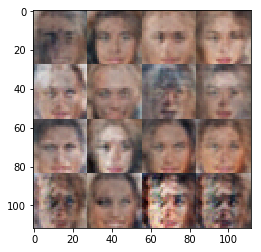

Epoch: 1, Batch: 1550, Disc. Loss: 0.955662, Gen. Loss: 1.612901
Epoch: 1, Batch: 1600, Disc. Loss: 0.964134, Gen. Loss: 1.288894
Epoch: 1, Batch: 1650, Disc. Loss: 1.384548, Gen. Loss: 0.520915
Epoch: 1, Batch: 1700, Disc. Loss: 1.253873, Gen. Loss: 0.756898
Epoch: 1, Batch: 1750, Disc. Loss: 0.755556, Gen. Loss: 1.208831
Epoch: 1, Batch: 1800, Disc. Loss: 1.435955, Gen. Loss: 0.557265
Epoch: 1, Batch: 1850, Disc. Loss: 1.177911, Gen. Loss: 0.940503
Epoch: 1, Batch: 1900, Disc. Loss: 1.166002, Gen. Loss: 0.748870
Epoch: 1, Batch: 1950, Disc. Loss: 1.264083, Gen. Loss: 0.692946
Epoch: 1, Batch: 2000, Disc. Loss: 1.094342, Gen. Loss: 2.901365


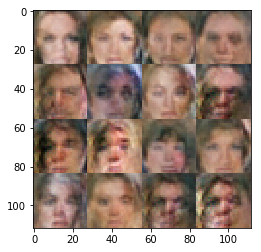

Epoch: 1, Batch: 2050, Disc. Loss: 1.166336, Gen. Loss: 0.628510
Epoch: 1, Batch: 2100, Disc. Loss: 1.065337, Gen. Loss: 1.014222
Epoch: 1, Batch: 2150, Disc. Loss: 1.469747, Gen. Loss: 0.573537
Epoch: 1, Batch: 2200, Disc. Loss: 0.835969, Gen. Loss: 2.357954
Epoch: 1, Batch: 2250, Disc. Loss: 1.246877, Gen. Loss: 0.619717
Epoch: 1, Batch: 2300, Disc. Loss: 0.961760, Gen. Loss: 1.099399
Epoch: 1, Batch: 2350, Disc. Loss: 1.159247, Gen. Loss: 1.002641
Epoch: 1, Batch: 2400, Disc. Loss: 1.189435, Gen. Loss: 0.850140
Epoch: 1, Batch: 2450, Disc. Loss: 1.384686, Gen. Loss: 0.666862
Epoch: 1, Batch: 2500, Disc. Loss: 1.505365, Gen. Loss: 0.430968


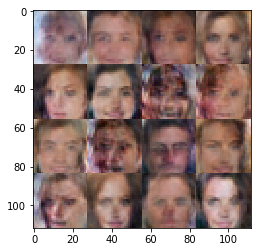

Epoch: 1, Batch: 2550, Disc. Loss: 0.999086, Gen. Loss: 1.257018
Epoch: 1, Batch: 2600, Disc. Loss: 1.633515, Gen. Loss: 0.368547
Epoch: 1, Batch: 2650, Disc. Loss: 1.418566, Gen. Loss: 0.529772
Epoch: 1, Batch: 2700, Disc. Loss: 1.113368, Gen. Loss: 0.857463
Epoch: 1, Batch: 2750, Disc. Loss: 1.249694, Gen. Loss: 0.977448
Epoch: 1, Batch: 2800, Disc. Loss: 1.129875, Gen. Loss: 0.930798
Epoch: 1, Batch: 2850, Disc. Loss: 1.078629, Gen. Loss: 0.804859
Epoch: 1, Batch: 2900, Disc. Loss: 0.945835, Gen. Loss: 1.153335
Epoch: 1, Batch: 2950, Disc. Loss: 1.071112, Gen. Loss: 2.513656
Epoch: 1, Batch: 3000, Disc. Loss: 1.144480, Gen. Loss: 1.122820


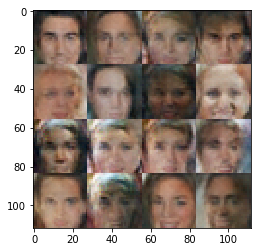

Epoch: 1, Batch: 3050, Disc. Loss: 1.472413, Gen. Loss: 0.573361
Epoch: 1, Batch: 3100, Disc. Loss: 1.229941, Gen. Loss: 1.001635
Epoch: 1, Batch: 3150, Disc. Loss: 0.944817, Gen. Loss: 2.242226
Epoch: 1, Batch: 3200, Disc. Loss: 1.228356, Gen. Loss: 0.751089
Epoch: 1, Batch: 3250, Disc. Loss: 0.974177, Gen. Loss: 1.225542
Epoch: 1, Batch: 3300, Disc. Loss: 1.076814, Gen. Loss: 1.050732
Epoch: 1, Batch: 3350, Disc. Loss: 1.035642, Gen. Loss: 1.939779
Epoch: 1, Batch: 3400, Disc. Loss: 1.562891, Gen. Loss: 0.444806
Epoch: 1, Batch: 3450, Disc. Loss: 1.067258, Gen. Loss: 0.990748
Epoch: 1, Batch: 3500, Disc. Loss: 1.154039, Gen. Loss: 1.030040


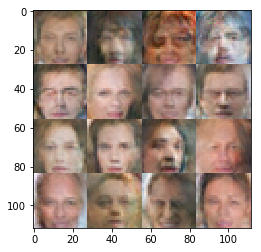

Epoch: 1, Batch: 3550, Disc. Loss: 1.173198, Gen. Loss: 0.716571
Epoch: 1, Batch: 3600, Disc. Loss: 0.983158, Gen. Loss: 1.231422
Epoch: 1, Batch: 3650, Disc. Loss: 1.061736, Gen. Loss: 2.050432
Epoch: 1, Batch: 3700, Disc. Loss: 2.374006, Gen. Loss: 0.258002
Epoch: 1, Batch: 3750, Disc. Loss: 1.035769, Gen. Loss: 1.270028
Epoch: 1, Batch: 3800, Disc. Loss: 1.113897, Gen. Loss: 1.025422
Epoch: 1, Batch: 3850, Disc. Loss: 0.927859, Gen. Loss: 2.488726
Epoch: 1, Batch: 3900, Disc. Loss: 1.238367, Gen. Loss: 0.709396
Epoch: 1, Batch: 3950, Disc. Loss: 0.881582, Gen. Loss: 1.697262
Epoch: 1, Batch: 4000, Disc. Loss: 0.957369, Gen. Loss: 1.377305


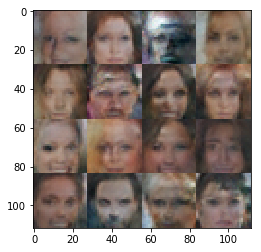

Epoch: 1, Batch: 4050, Disc. Loss: 1.267996, Gen. Loss: 0.560529
Epoch: 1, Batch: 4100, Disc. Loss: 1.464828, Gen. Loss: 0.462821
Epoch: 1, Batch: 4150, Disc. Loss: 1.377322, Gen. Loss: 0.647950
Epoch: 1, Batch: 4200, Disc. Loss: 1.180098, Gen. Loss: 0.723127
Epoch: 1, Batch: 4250, Disc. Loss: 1.265175, Gen. Loss: 0.698741
Epoch: 1, Batch: 4300, Disc. Loss: 1.331447, Gen. Loss: 0.859392
Epoch: 1, Batch: 4350, Disc. Loss: 1.310087, Gen. Loss: 0.578179
Epoch: 1, Batch: 4400, Disc. Loss: 1.752348, Gen. Loss: 0.311162
Epoch: 1, Batch: 4450, Disc. Loss: 1.236450, Gen. Loss: 0.667990
Epoch: 1, Batch: 4500, Disc. Loss: 1.361283, Gen. Loss: 0.751129


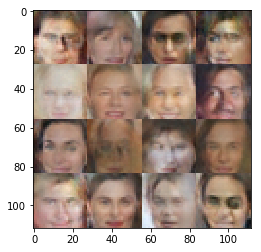

Epoch: 1, Batch: 4550, Disc. Loss: 1.532182, Gen. Loss: 0.457369
Epoch: 1, Batch: 4600, Disc. Loss: 1.392441, Gen. Loss: 1.101701
Epoch: 1, Batch: 4650, Disc. Loss: 1.322993, Gen. Loss: 0.787936
Epoch: 1, Batch: 4700, Disc. Loss: 1.423805, Gen. Loss: 0.496358
Epoch: 1, Batch: 4750, Disc. Loss: 1.883184, Gen. Loss: 0.335228
Epoch: 1, Batch: 4800, Disc. Loss: 1.352232, Gen. Loss: 0.701800
Epoch: 1, Batch: 4850, Disc. Loss: 1.283989, Gen. Loss: 0.617811
Epoch: 1, Batch: 4900, Disc. Loss: 1.491449, Gen. Loss: 0.525999
Epoch: 1, Batch: 4950, Disc. Loss: 1.529178, Gen. Loss: 0.481851
Epoch: 1, Batch: 5000, Disc. Loss: 1.457035, Gen. Loss: 0.487871


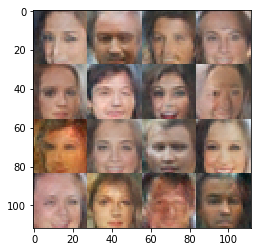

Epoch: 1, Batch: 5050, Disc. Loss: 1.019566, Gen. Loss: 1.124519
Epoch: 1, Batch: 5100, Disc. Loss: 1.859783, Gen. Loss: 0.360565
Epoch: 1, Batch: 5150, Disc. Loss: 1.371745, Gen. Loss: 0.640185
Epoch: 1, Batch: 5200, Disc. Loss: 1.451094, Gen. Loss: 0.510225
Epoch: 1, Batch: 5250, Disc. Loss: 1.175839, Gen. Loss: 1.728695
Epoch: 1, Batch: 5300, Disc. Loss: 1.160536, Gen. Loss: 0.733515
Epoch: 1, Batch: 5350, Disc. Loss: 1.140867, Gen. Loss: 0.955249
Epoch: 1, Batch: 5400, Disc. Loss: 0.995364, Gen. Loss: 1.530173
Epoch: 1, Batch: 5450, Disc. Loss: 1.123618, Gen. Loss: 1.179611
Epoch: 1, Batch: 5500, Disc. Loss: 1.348835, Gen. Loss: 0.894704


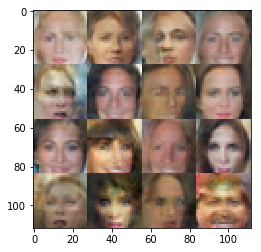

Epoch: 1, Batch: 5550, Disc. Loss: 1.311094, Gen. Loss: 0.682558
Epoch: 1, Batch: 5600, Disc. Loss: 1.034939, Gen. Loss: 1.831695
Epoch: 1, Batch: 5650, Disc. Loss: 1.022713, Gen. Loss: 1.339035
Epoch: 1, Batch: 5700, Disc. Loss: 0.893677, Gen. Loss: 2.240363
Epoch: 1, Batch: 5750, Disc. Loss: 1.931068, Gen. Loss: 0.481734
Epoch: 1, Batch: 5800, Disc. Loss: 1.682719, Gen. Loss: 0.337093
Epoch: 1, Batch: 5850, Disc. Loss: 1.077353, Gen. Loss: 1.167051
Epoch: 1, Batch: 5900, Disc. Loss: 1.141973, Gen. Loss: 0.867780
Epoch: 1, Batch: 5950, Disc. Loss: 1.113126, Gen. Loss: 2.826609
Epoch: 1, Batch: 6000, Disc. Loss: 1.312550, Gen. Loss: 0.641308


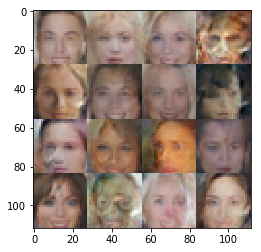

Epoch: 1, Batch: 6050, Disc. Loss: 1.367969, Gen. Loss: 0.668025
Epoch: 1, Batch: 6100, Disc. Loss: 1.855027, Gen. Loss: 0.318602
Epoch: 1, Batch: 6150, Disc. Loss: 0.678313, Gen. Loss: 2.355702
Epoch: 1, Batch: 6200, Disc. Loss: 0.920045, Gen. Loss: 3.486815
Epoch: 1, Batch: 6250, Disc. Loss: 1.143084, Gen. Loss: 0.803935
Epoch: 1, Batch: 6300, Disc. Loss: 1.324589, Gen. Loss: 1.049534


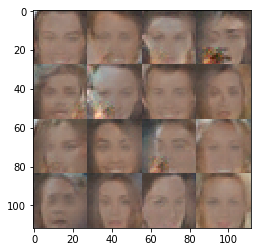

In [14]:
batch_size = 32
z_dim = 300
learning_rate = 0.0002
beta1 = 0.5
alpha=0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha=alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.